# Benchmarking Retrievers

In [57]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wikipedia
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
from math import log2
from urllib.request import urlopen

In [45]:
sns.set_style('darkgrid')
sns.set(font_scale=1.2)
plt.rcParams['font.family'] = 'Serif'

In [7]:
filepaths = []
directory = 'retrievers_benchmark'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        filepaths.append(f)

In [32]:
mapping = {
    0.0: 0,
    1.0: 1,
    2.1: 2,
    2.2: 3,
    2.3: 4,
    3.0: 5
}

for filepath in filepaths:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['BM25 Rank'] = df.index + 1
    df.to_csv(filepath, index=False)

In [38]:
df = pd.read_csv('/content/retrievers_benchmark/campbell2017grammar.csv')

## Metric: Normalized Discounted Cumulative Gain (NDCG@K)

In [27]:
def ndcg(relevance_scores):
    ideal_relevance_scores = sorted(relevance_scores, reverse=True)

    dcg = 0
    idcg = 0
    ndcg = []

    for k in range(1, len(relevance_scores) + 1):
        rel_k = relevance_scores[k-1]
        ideal_rel_k = ideal_relevance_scores[k-1]
        dcg += rel_k / log2(k + 1)
        idcg += ideal_rel_k / log2(k + 1)
        ndcg.append(dcg / idcg)

    return ndcg

## The Only Language-Agnostic Ranker (aka Baseline): BM25

In [36]:
for filepath in filepaths:
    df = pd.read_csv(filepath)
    df['Relevance Score'] = df['Annotation'].map(mapping)
    df['BM25 Rank'] = df.index + 1
    df['BM25 NDCG@K'] = ndcg(df['Relevance Score'])
    df.to_csv(filepath, index=False)

## Wikipedia Summary as Query

In [50]:
def get_query(term, language):
    soup = BeautifulSoup(urlopen('http://en.wikipedia.org/wiki/' + (term[:1].upper() + term[1:]).replace(' ', '_')), features="lxml")
    interwikihead = soup.find('li', class_=('interlanguage-link interwiki-' + language + ' mw-list-item'))

    try:
        if language == 'en':
            title = term[:1].upper() + term[1:]
        else:
            title = interwikihead.a.get('title').split(u' – ')[0]
        wikipedia.set_lang(language)
        page = wikipedia.page(title, auto_suggest=False)
        return page.summary
    except:
        return None

In [54]:
query = get_query('Word order', 'en')
query

'In linguistics, word order (also known as linear order) is the order of the syntactic constituents of a language. Word order typology studies it from a cross-linguistic perspective, and examines how languages employ different orders. Correlations between orders found in different syntactic sub-domains are also of interest. The primary word orders that are of interest are\n\nthe constituent order of a clause, namely the relative order of subject, object, and verb;\nthe order of modifiers (adjectives, numerals, demonstratives, possessives, and adjuncts) in a noun phrase;\nthe order of adverbials.\nSome languages use relatively fixed word order, often relying on the order of constituents to convey grammatical information. Other languages—often those that convey grammatical information through inflection—allow more flexible word order, which can be used to encode pragmatic information, such as topicalisation or focus. However, even languages with flexible word order have a preferred or ba

## Embeddings

https://huggingface.co/spaces/mteb/leaderboard

Retrieval English Leaderboard 🔎

Metric: Normalized Discounted Cumulative Gain @ k (ndcg_at_10)

### SFR-Embedding-Mistral

In [ ]:
model = SentenceTransformer('Salesforce/SFR-Embedding-Mistral')

def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

def get_scores(query, passages):
    # Each query must come with a one-sentence instruction that describes the task
    task = 'Given a web search query, retrieve relevant passages that answer the query'
    queries = [get_detailed_instruct(task, query)] * len(passages)
    # No need to add instruction for retrieval documents
    embeddings = model.encode(queries + passages)
    scores = util.cos_sim(embeddings[:2], embeddings[2:]) * 100
    return scores.tolist()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.3k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.28G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
get_scores(

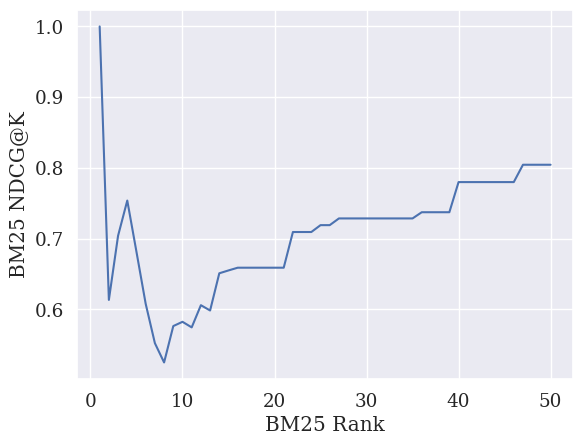

In [46]:
sns.lineplot(data=df, x='BM25 Rank', y='BM25 NDCG@K');